In [1]:
import os
import re
import json
import spacy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy
from read_problems import read_questions_json
from read_problems import read_all_problems
from read_problems import write_problems
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokenizer import Tokenizer
from spacy.symbols import nsubj, VERB, root, nsubjpass, det
%matplotlib inline

In [3]:
class QuestionCategory(object):
    # The subject of the question is the definition and
    # the choices contain the potential technical term associated to it
    DEF_KEYWORD = 0
    # The subject of the question is the definition and
    # the rest of the question contains the beginning of the technical term
    # and the choices contain the potential end of the technical term
    DEF_KEYWORD_START_END = 1
    
    # The subject of the question is a technical term or very close to it and
    # the proposed choices are the potential definitions of the technical term
    KEYWORD_DEF = 2
    # The subject of the question is a technical term or very close to it and
    # the rest of the question contains the beginning or a good part of the definition and
    # the choices contain the end of the definition
    KEYWORD_DEF_START_END = 3
    
    # The subject of the question is a characteristic and 
    # the proposed choices are the potential technical terms exposing this characteristic
    CHAR_KEYWORD = 4
    # The subject of the question is a technical term and 
    # the proposed choices are the potential characteristics associated with this characteristic
    KEYWORD_CHAR = 5
    
    CONTEXT_KEYWORD_CHAR = 6
    
    # The question is quite complex. The subject of the description refers to a previous sentence in the question
    SITUATION_KEYWORD = 7
    
    # Very hard
    KEYWORD_COMPARISON = 8
    CALCULUS = 9
    REASONING = 10
    BEST_ASSOCIATION = 11
    
    # Will probably never care
    OCR_PROBLEM = 20
    
    UNLABELED = 666

In [4]:
def get_enum_name(enum_class, enum_value):
    enum_names = {value: name for name, value in vars(enum_class).items() if name.isupper()}
    return enum_names[enum_value]

In [6]:
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en')
wiki_nlp = spacy.load('xx_ent_wiki_sm')

In [170]:
def load_glossary():
    path = os.path.join('..', 'Data', 'material_handbook', 'glossary_manual.json')
    return json.load(open(path))

def calculate_average_question_len(q):
    res = q['choice_A_len'] + \
          q['choice_B_len'] + \
          q['choice_C_len']
    if q['choice_D'] is np.NaN:
        return res / 3
    res += q['choice_D_len']
    return res / 4

def add_length_features(df):
    df['question_len'] = df['question'].str.len()
    df['choice_A_len'] = df['choice_A'].str.len()
    df['choice_B_len'] = df['choice_B'].str.len()
    df['choice_C_len'] = df['choice_C'].str.len()
    df['choice_D_len'] = df['choice_D'].str.len()
    df['average_question_len'] = df.apply(calculate_average_question_len, axis=1)
    df['question_choice_len_ratio'] = df['question_len'] / df['average_question_len']

def is_roman(word):
    return re.match('^[IVXLC]+$', word) is not None

def get_keyword(term):
    words = term.split(' ')
    words = [x.lower() for x in words if is_roman(x) or x.lower() not in STOP_WORDS]
    return ' '.join(words)

def is_in_glossary(term, glossary):
    if term is np.NaN:
        return False
    keyword = term
    if keyword not in glossary:
        keyword = get_keyword(term)
    return keyword in glossary
    
def sentence_with_term(sentence, glossary):
    if sentence is np.NaN:
        return False
    for keyword, definition in glossary.items():
        if keyword.lower() in sentence.lower():
            return True
    return False

def any_choice_in_glossary(df):
    if df['choice_D'] is np.NaN:
        return df['choice_A_in_glossary'] or \
               df['choice_B_in_glossary'] or \
               df['choice_C_in_glossary']
    return df['choice_A_in_glossary'] or \
           df['choice_B_in_glossary'] or \
           df['choice_C_in_glossary'] or \
           df['choice_D_in_glossary']

def has_numbers(problem):
    question = problem['question']
    for token in problem['question_nlp']:
        if re.match("^[0-9]+[.,]?[0-9]+$", str(token)) is not None:
            return True
    return False

def has_numbers_nlp(problem):
    question = problem['question']
    for token in problem['question_nlp']:
        if token.is_digit:
            return True
    return False

def get_ner(problem, nlp_q):
    question = problem['question']
    ent_type_ids = set()
    ent_types = []
    for token in problem[nlp_q]:
        if token.ent_type != 0 and token.ent_type not in ent_type_ids:
            ent_type_ids.add(token.ent_type)
            ent_types.append(token.ent_type_)
    if len(ent_types) == 0:
        return None
    return ent_types

def get_verb_centrality(problem):
    index = -1
    for i, token in enumerate(problem['question_nlp']):
        t = str(token)
        if t == 'defined' or t == 'described':
            index = i
            break
    if index == -1:
        return -1
    nb_tokens = len(problem['question_nlp'])
    res = (index + 1) / nb_tokens
    if nb_tokens % 2 == 1:
        res -= 1 / (2 * nb_tokens)
    return res

def has_ner(problem):
    ent_types = problem['question_ner']
    return ent_types is not None and ('PERSON' in ent_types or 'PERCENT' in ent_types)

def is_def_word(word):
    return word == 'described' or word == 'defined'

def get_definition_subject(problem):
    question = problem['question']
    q_nlp = nlp(question, disable=['ner', 'textcat'])
    subject = []
    for token in reversed(q_nlp):
        if token.pos != VERB or not is_def_word(token.text):
            continue
        while token != token.head:
            token = token.head
        for child in token.children:
            if child.dep != nsubj and child.dep != nsubjpass:
                continue            
            subtree = list(child.subtree)
            if subtree[0].dep == det:
                subtree = subtree[1:]
            subject = ''.join(map(lambda x: x.text_with_ws, subtree))
            return subject.strip().lower()
    return ''

def extract_choice_query_keywords(problem):
    subject = get_definition_subject(problem)
    choiceA = (problem['choice_A'] + ' ' + subject).strip()
    choiceB = (problem['choice_B'] + ' ' + subject).strip()
    choiceC = (problem['choice_C'] + ' ' + subject).strip()
    if 'choice_D' not in problem or problem['choice_D'] is np.NaN:
        return (choiceA, choiceB, choiceC)
    choiceD = (problem['choice_D'] + ' ' + subject).strip()
    return (choiceA, choiceB, choiceC, choiceD)

def choice_with_q_subject_in_glossary(problem, glossary):
    keywords = problem['choice_q_keywords']
    for keyword in keywords:
        if is_in_glossary(keyword, glossary):
            return True
    return False

def get_loose_glossary_key(term, glossary):
    keys = glossary.keys()
    for key in keys:
        if key in term:
            return key
    return None

def is_loosly_in_glossary(problem):
    return problem['q_gloss_key'] is not None

def add_glossary_features(df):
    glossary = load_glossary()
    df['choice_A_in_glossary'] = df['choice_A'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_B_in_glossary'] = df['choice_B'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_C_in_glossary'] = df['choice_C'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['choice_D_in_glossary'] = df['choice_D'].apply(lambda choice: is_in_glossary(choice, glossary))
    df['any_choice_in_glossary'] = df.apply(any_choice_in_glossary, axis=1)
    df['choice_q_keywords'] = df.apply(extract_choice_query_keywords, axis=1)
    df['choice_with_q_subject_in_glossary'] = df.apply(lambda p: choice_with_q_subject_in_glossary(p, glossary), axis=1)
    df['q_subject'] = df.apply(get_definition_subject, axis=1)
    df['q_gloss_key'] = df['q_subject'].apply(lambda s: get_loose_glossary_key(s, glossary))
    df['q_subject_loosly_in_gloss'] = df.apply(is_loosly_in_glossary, axis=1)

def add_features(nlp, wiki_nlp, df):
    add_length_features(df)
    add_glossary_features(df)
    df['question_nlp'] = df['question'].apply(lambda q: nlp(q))
    df['question_wiki_nlp'] = df['question'].apply(lambda q: wiki_nlp(q))
    df['question_has_digits'] = df.apply(has_numbers, axis=1)
    df['question_has_digits_nlp'] = df.apply(has_numbers_nlp, axis=1)
    df['question_ner'] = df.apply(lambda p: get_ner(p, 'question_nlp'), axis=1)
    df['question_has_ner'] = df.apply(has_ner, axis=1)
    df['question_verb_centrality'] = df.apply(get_verb_centrality, axis=1)

def predict(df, category, filters_factory):
    df.loc[filters_factory(df), 'predicted_category'] = category

def clean_features(df):
    df.drop(['question_len', 'choice_A_len', 'choice_B_len', 'choice_C_len', 'choice_D_len', 'average_question_len', 'filename', 'comments', 'choice_A_in_glossary', 'choice_B_in_glossary', 'choice_C_in_glossary', 'choice_D_in_glossary'], axis=1, inplace=True)
    
def predict_category(categories, names, filters_factories, with_df=None):
    if with_df is None:
        df = read_all_problems()
        df['real_category'] = df['category'].copy()
        add_features(nlp, wiki_nlp, df)
    else:
        df = with_df
        df['category'] = df['real_category'].copy()

    df['predicted_category'] = QuestionCategory.UNLABELED
    filters = df['category'] != categories[0]
    for category in categories[1:]:
        filters &= df['category'] != category
    df.loc[filters, 'category'] = QuestionCategory.UNLABELED

    for i, filter_factory in enumerate(filters_factories):
        predict(df, categories[i], filter_factory)
        
    y_pred = df['predicted_category']
    y_test = df['category']
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), names)
    print(classification_report(y_test, y_pred, target_names=names))
    
    return df

In [159]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize='x-large')
    plt.yticks(tick_marks, classes, fontsize='x-large')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/ipykernel_launcher.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/ipykernel_launcher.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Confusion matrix, without normalization
                                    precision    recall  f1-score   support

               Définition => Sujet       0.75      0.93      0.83        29
Définition + début => Fin de sujet       1.00      0.67      0.80         3
               Sujet => Définition       0.60      0.90      0.72        10
Sujet + début => Fin de définition       0.83      0.36      0.50        14
                             Autre       0.82      0.78      0.80        60

                       avg / total       0.79      0.78      0.77       116



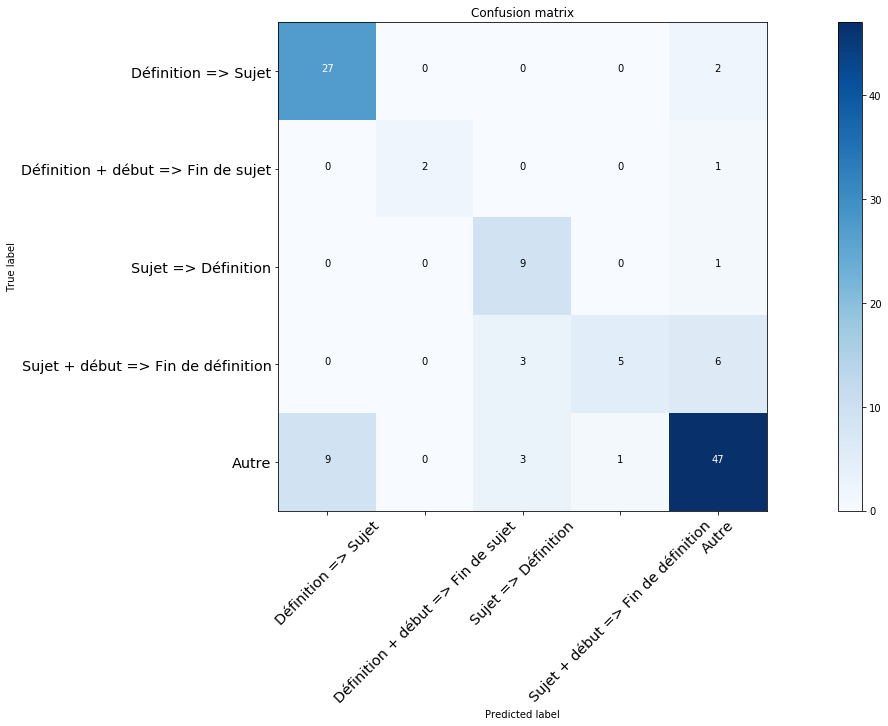

In [171]:
def get_def_keyword_filters_base(df):
    filters = df['predicted_category'] == QuestionCategory.UNLABELED
    filters &= ~df['question'].str.contains(', CFA,')
    filters &= df['question_choice_len_ratio'] < 27.0
    filters &= df['question_verb_centrality'] > 0.6
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    return filters

def get_def_keyword_filters(df):
    filters = get_def_keyword_filters_base(df)
    filters &= df['any_choice_in_glossary']
    return filters

def get_def_keyword_start_end_filters(df):
    filters = get_def_keyword_filters_base(df)
    filters &= df['choice_with_q_subject_in_glossary']
    return filters

def get_keyword_def_filter(df):
    filters = df['predicted_category'] == QuestionCategory.UNLABELED
    filters &= ~df['question'].str.contains(', CFA,')
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    filters &= df['q_subject_loosly_in_gloss']
    filters &= df['question_choice_len_ratio'] < 2.0
    return filters

def get_keyword_def_start_end_filter(df):
    filters = df['predicted_category'] == QuestionCategory.UNLABELED
    filters &= ~df['question'].str.contains(', CFA,')
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    filters &= df['q_subject_loosly_in_gloss']
    filters &= df['question_verb_centrality'] < 0.6
    return filters

categories = [
    QuestionCategory.DEF_KEYWORD,
    QuestionCategory.DEF_KEYWORD_START_END,
    QuestionCategory.KEYWORD_DEF,
    QuestionCategory.KEYWORD_DEF_START_END,
]
names = [
    "Définition => Sujet",
    "Définition + début => Fin de sujet",
    "Sujet => Définition",
    "Sujet + début => Fin de définition",
    "Autre"
]
filters = [
    get_def_keyword_filters,
    get_def_keyword_start_end_filters,
    get_keyword_def_filter,
    get_keyword_def_start_end_filter
]

def_filters = all_df['question'].str.contains('described')
def_filters |= all_df['question'].str.contains('defined')
defs = all_df[def_filters]
defs = predict_category(categories, names, filters, defs)

In [ ]:
all_df[all_df['real_category'] == QuestionCategory]

Confusion matrix, without normalization
             precision    recall  f1-score   support

          1       0.25      0.40      0.31         5
        666       1.00      1.00      1.00      2081

avg / total       1.00      1.00      1.00      2086



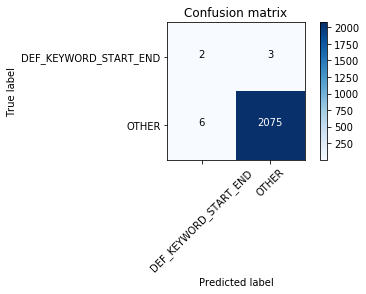

In [67]:
all_df = predict_category(QuestionCategory.DEF_KEYWORD_START_END, get_def_keyword_start_end_filters, all_df)

Confusion matrix, without normalization
             precision    recall  f1-score   support

          2       0.60      0.90      0.72        10
        666       1.00      1.00      1.00      2076

avg / total       1.00      1.00      1.00      2086



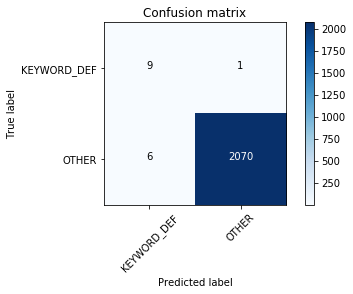

In [204]:


all_df = predict_category(QuestionCategory.KEYWORD_DEF, get_keyword_def_filter, all_df)

In [187]:
filters = all_df['predicted_category'] == QuestionCategory.KEYWORD_DEF
filters &= all_df['real_category'] != QuestionCategory.KEYWORD_DEF
all_df.loc[filters, 'real_category'].apply(lambda x: get_enum_name(QuestionCategory, x))

318     KEYWORD_DEF_START_END
969              KEYWORD_CHAR
1323    KEYWORD_DEF_START_END
1697    KEYWORD_DEF_START_END
1921         BEST_ASSOCIATION
1981         BEST_ASSOCIATION
Name: real_category, dtype: object

Confusion matrix, without normalization
             precision    recall  f1-score   support

          5       0.22      0.29      0.25         7
        666       1.00      1.00      1.00      2079

avg / total       0.99      0.99      0.99      2086



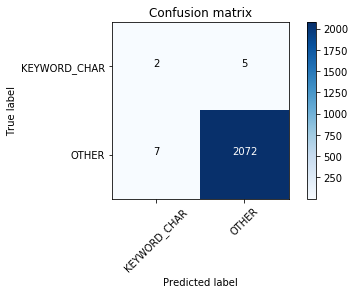

In [249]:
def get_keyword_def_filter(df):
    filters = ~df['question'].str.contains(', CFA,')
    filters &= (df['question'].str.contains('described as') |
               df['question'].str.contains('defined as'))
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    filters &= df['q_subject_loosly_in_gloss']
    filters &= df['question_choice_len_ratio'] > 2.0
    filters &= df['question_verb_centrality'] > 0.6
    filters &= ~df['any_choice_in_glossary']
    filters &= df['real_category'] != QuestionCategory.DEF_KEYWORD
    filters &= df['real_category'] != QuestionCategory.DEF_KEYWORD_START_END
    return filters

all_df = predict_category(QuestionCategory.KEYWORD_CHAR, get_keyword_def_filter)

In [229]:
filters = all_df['predicted_category'] == QuestionCategory.KEYWORD_CHAR
filters &= all_df['real_category'] != QuestionCategory.KEYWORD_CHAR
all_df.loc[filters, 'real_category'].apply(lambda x: get_enum_name(QuestionCategory, x))

606          CHAR_KEYWORD
855     SITUATION_KEYWORD
1115         CHAR_KEYWORD
1353     BEST_ASSOCIATION
1441          OCR_PROBLEM
1568     BEST_ASSOCIATION
1759         CHAR_KEYWORD
Name: real_category, dtype: object

In [250]:
filters = all_df['predicted_category'] == QuestionCategory.KEYWORD_CHAR
filters &= all_df['real_category'] != QuestionCategory.KEYWORD_CHAR

all_df.loc[filters, ('question', 'real_category', 'q_subject', 'q_gloss_key', 'q_subject_loosly_in_gloss', 'question_has_ner', 'question_has_digits')]

,question,real_category,q_subject,q_gloss_key,q_subject_loosly_in_gloss,question_has_ner,question_has_digits
606,"For an investment portfolio, the coefficient o...",4,coefficient of variation of the returns on the...,coefficient of variation,True,False,False
855,Suppose inflation increases due to increases i...,6,such inflation,inflation,True,False,False
1115,"Under the IASB Conceptual Framework, one of th...",6,characteristic,character,True,False,False
1353,According to the International Accounting Stan...,10,two fundamental qualitative characteristics th...,character,True,False,False
1441,When an investigator wants to test whether a p...,20,null and alternative hypothesis,hypothesis,True,False,False
1568,The SEC's approach to addressing the significa...,10,sec's approach to addressing the significant d...,repo,True,False,False
1759,Under the International Accounting Standards B...,4,characteristic,character,True,False,False


In [244]:
all_df.loc[1115, 'question']

'Under the IASB Conceptual Framework, one of the qualitative characteristics of useful financial information is that different knowledgeable users would agree that the information is a faithful representation of the economic events that it is intended to represent. This characteristic is best described as:'

In [243]:
all_df.loc[1115]

answer                                                         A
category                                                       6
choice_A                                           verifiability
choice_B                                           comparability
choice_C                                       understandability
choice_D                                                     NaN
comments       "Financial Reporting Standards," Elaine Henry,...
filename                                 2012_morning_answer.xml
question       Under the IASB Conceptual Framework, one of th...
question_nb                                                   59
topic                               Financial Statement Analysis
year                                                        2012
Name: 1115, dtype: object

In [241]:
all_df = read_all_problems()
all_df.loc[606, 'category'] = QuestionCategory.BEST_ASSOCIATION
write_problems(all_df)

In [181]:
keyword_chars = all_df[all_df['real_category'] == QuestionCategory.KEYWORD_CHAR]
keyword_chars[['question_has_digits', 'question_has_ner', 'q_subject', 'q_subject_loosly_in_gloss', 'question_choice_len_ratio']]

,question_has_digits,question_has_ner,q_subject,q_subject_loosly_in_gloss,question_choice_len_ratio
611,False,False,kurtosis,True,10.406250
722,False,False,central limit theorem,False,3.364286
969,False,False,consumer surplus,True,1.000000
1202,False,False,wave 2,False,1.274611
1467,False,False,which of the following,False,2.198758
1470,False,False,"conceptual framework for financial reporting, ...",True,6.342857
1684,False,False,equity return distributions,True,4.421053


In [188]:
all_df.loc[1467]

answer                                                                               A
category                                                                           666
choice_A                                      Transparency to the underlying economics
choice_B                             Consistency in the measurement basis used acro...
choice_C                             Uniform treatment of transactions by different...
choice_D                                                                           NaN
comments                             An effective framework should enhance the tran...
filename                                                     2016_morning_question.xml
question                             Which of the following is best described as a ...
question_nb                                                                         56
topic                                                     Financial Statement Analysis
year                                       

In [142]:
all_df.loc[1470, 'q_subject']

'conceptual framework for financial reporting, the two fundamental qualitative characteristics that make financial information useful'

In [30]:
def get_keyword_def_start_end_filter(df):
    filters = ~df['question'].str.contains(', CFA,')
    filters &= (df['question'].str.contains('described as') |
               df['question'].str.contains('defined as'))
    filters &= ~df['question_has_digits']
    filters &= ~df['question_has_ner']
    filters &= df['q_subject_loosly_in_gloss']
    filters &= df['question_verb_centrality'] < 0.6
    return filters

all_df = predict_category(QuestionCategory.KEYWORD_DEF_START_END, get_keyword_def_filter)

NameError: name 'get_keyword_def_filter' is not defined

In [75]:
filters = all_df['real_category'] == QuestionCategory.KEYWORD_DEF_START_END
# all_df.loc[filters, ('q_subject', 'q_subject_loosly_in_gloss', 'question_verb_centrality')]
all_df.loc[filters, ('question', 'choice_A', 'choice_B')]

,question,choice_A,choice_B
27,Which of the following statements regarding co...,product of the variables' variances,variance of the dependent variable
192,A company's optimal capital budget is best des...,marginal cost of capital,cost of new debt capital
318,Free cash flow to equity is most accurately de...,only interest payments to debt holders,payments to both debt holders (interest and pr...
376,Which of the following statements best describ...,variances,standard deviations
507,The quantity theory of money is best described...,equal,lower
556,A derivative is most accurately defined as a f...,a return based on the return of another asset,an adjustment to another asset’s level of risk
730,A test statistic is best defined as the differ...,sample standard deviation,standard error of the sample statistic
1091,First degree price discrimination is best desc...,increases,decreases
1323,The liquidity premium can be best described as...,risk of loss relative to an investment's fair ...,increased sensitivity of the market value of d...
1477,The optimal capital budget for a firm is best ...,less than the investment opportunity schedule,equal to the investment opportunity schedule


In [112]:
def get_verb_token(problem):
    tokens = problem['question_nlp']
    for i, token in enumerate(reversed(tokens)):
        if token.text == 'defined' or token.text == 'described':
            return len(tokens) - 1 - i, token
    return -1, None

def get_right_of_verb(problem):
    tokens = problem['question_nlp']
    i_token, token = get_verb_token(problem)
    right = ''.join(map(lambda t: t.text_with_ws, tokens[i_token + 1:]))
    if right.endswith(':'):
        right = right[:len(right) - 1]
    return right.strip()

filters = all_df['real_category'] == QuestionCategory.KEYWORD_DEF_START_END

with pd.option_context('display.max_colwidth', 500):
    print(all_df.loc[filters].apply(get_right_of_verb, axis=1))

27                                      Which of the following statements regarding correlation and covariance is most likely correct? The correlation  between two random variables is their covariance standardized by the
192                                                                                                        as the amount of new capital required to undertake all projects with an  internal rate of return greater than the
318                                                                                                                                                                                 as operating free cash flow adjusted for
376     Which of the following statements best describes the relationship between correlation and covariance? The correlation between two random variables is their covariance standardized by the product of the variables’
507                                                                                   as the proposition that, in th

In [104]:
all_df.loc[192]

answer                                                                               D
category                                                                             3
choice_A                                                      marginal cost of capital
choice_B                                                      cost of new debt capital
choice_C                                                     cost of retained earnings
choice_D                                              weighted average cost of capital
comments                             “Cost of Capital,” Yves Courtois, GeneC. Lai, ...
filename                                                               2008_part_2.xml
question                             A company's optimal capital budget is best des...
question_nb                                                                         73
topic                                                                Corporate Finance
year                                       

In [873]:
def extract_keyword(problem):
    subject = get_definition_subject(problem)
    choiceA = problem['choice_A'] + ' ' + subject
    choiceB = problem['choice_B'] + ' ' + subject 
    choiceC = problem['choice_C'] + ' ' + subject
    if 'choice_D' not in problem or problem['choice_D'] is np.NaN:
        return (choiceA, choiceB, choiceC)
    choiceD = problem['choice_D'] + ' ' + subject
    return (choiceA, choiceB, choiceC, choiceD)

target = all_df[all_df['real_category'] == QuestionCategory.DEF_KEYWORD_START_END]
target = target.apply(extract_keyword, axis=1)

with pd.option_context('display.max_colwidth', 500):
    print(target)

26                                                                (a priori probability , objective probability , empirical probability , subjective probability )
375                                                                                       (a priori probability , empirical probability , subjective probability )
920                                                          (default risk investor’s fear , downgrade risk investor’s fear , credit spread risk investor’s fear )
1826    (a Student's t distribution of the future stock price , lognormal distribution of the future stock price , normal distribution of the future stock price )
1995                                                  (strong form of market efficiency , weak form of market efficiency , semi-strong form of market efficiency )
dtype: object


In [871]:
defs.loc[1995, 'question']

'If a test rejects the hypothesis that market prices reflect private information but does not reject the hypothesis that they reflect past market data and public information, then the form of market efficiency is best described as:'

In [124]:
def display_dependencies(sentence, options={}):
    doc = nlp(sentence)
    displacy.render(doc, style='dep', jupyter=True, options=options)
    
    
display_dependencies("The option adjusted spread is best described as:")

In [474]:
defs.loc[26, 'question']

'If an analyst estimates the probability of an event for which there is no historical record, this probability is best  described as:'

In [65]:
question = 'Which of the following statements regarding correlation and covariance is most likely correct? The correlation  between two random variables is their covariance standardized by the:'

def is_start_end_definition(question):
    match = re.match('^.*[.!?] The([^.!?]*) is [^.!?]*:$', question)
    return not match is None

def extract_last_sentence(question):
    match = re.match('^([^.!?]*[.!?:])+$', question)
    return match.group(1).strip()

extract_last_sentence(question)

'The correlation  between two random variables is their covariance standardized by the:'

In [551]:
test_df = read_all_problems()
test_defs = test_df[test_df['question'].str.contains("described") | test_df['question'].str.contains("defined")]
test_defs.drop(['comments'], axis=1, inplace=True)
test_defs[test_defs['category'] == QuestionCategory.OTHER]

/home/abiarnes/VirtualEnvs/MDI720/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,answer,category,choice_A,choice_B,choice_C,choice_D,filename,question,question_nb,topic,year
513,B,666,objective of financial reporting,general requirement for financial statements,qualitative characteristic of the IFRS Framework,NaN,2010_afternoon_answer.xml,Under International Financial Reporting Standards (IFRS) the preparation of a complete set of financial statements is best described as a(n):,50,Financial Statement Analysis,2010
517,C,666,the amount of proceeds received in exchange for the obligation,the discounted value of the future cash flows that are required to satisfy the obligation,the undiscounted amount of cash or cash equivalents expected to be paid to satisfy the obligation,NaN,2010_afternoon_answer.xml,The settlement value for a liability is best described as:,54,Financial Statement Analysis,2010
551,A,666,overvalued by $11.36,undervalued by $15.13,undervalued by $36.36,NaN,2010_afternoon_answer.xml,"A company’s $100 par perpetual preferred stock has a dividend rate of 7 percent and a required rate of return of 11 percent. The company’s earnings are expected to grow at a constant rate of 3 percent per year. If the market price per share for the preferred stock is $75, the preferred stock is most appropriately described as being:",88,Equity Investments,2010
555,C,666,loan to the futures trader,requirement set by federal regulators,down payment from the futures trader,NaN,2010_afternoon_answer.xml,Margin in the futures market is most accurately described as a:,92,Derivative Investments,2010
556,B,666,a return based on the return of another asset,an adjustment to another asset’s level of risk,an agreement between two parties to provide something for each other,NaN,2010_afternoon_answer.xml,A derivative is most accurately defined as a financial instrument that provides:,93,Derivative Investments,2010
654,B,666,equal for the two projects,lower for Project 1 than for Project 2,greater for Project 1 than for Project 2,NaN,2010_morning_answer.xml,"An analyst is developing net present value (NPV) profiles for two investment projects. The only difference between the two projects is that Project 1 is expected to receive larger cash flows early in the life of the project, while Project 2 is expected to receive larger cash flows late in the life of the project. The sensitivities of the projects’ NPVs to changes in the discount rate is best described as:",72,Corporate Finance,2010
848,B,666,H0: 9 = 90 versus Ha: 9 ^ 90,H0: 9 < 90 versus Ha: 9 > 90,H0: 9 > 90 versus Ha: 9 < 90,NaN,2011_morning_answer.xml,"When an investigator wants to test whether a particular parameter is larger than a specific value, the null and alternative hypothesis are best defined as:",29,Quantitative Methods,2011
852,B,666,fixed in the long run,variable in the long run,variable in the short run,NaN,2011_morning_answer.xml,"Regarding a company’s production function, both labor costs and capital costs are best described as:",34,Economics,2011
856,B,666,cost-push inflation,demand-pull inflation,monetarist cycle theory,NaN,2011_morning_answer.xml,Suppose inflation increases due to increases in government spending and a reduction in taxes. Such inflation is best described as:,38,Economics,2011
971,B,666,Qb and Qa,Qc and Qb,Qc and Qa,NaN,2012_afternoon_answer.xml,"The diagram illustrates a consumer's allocation of her budget between items X and Y. With an initial budget (BC1) she consumes Qa units of item Y. When the price of Y drops, she consumes Qc units of item Y. Lines BC2 and BC3 are parallel to one another. The income effect arising from this change in the price of Y is best described as the distance between:",34,Economics,2012


In [600]:
all_df.loc[513, 'question']

'Under International Financial Reporting Standards (IFRS) the preparation of a complete set of financial statements is best described as a(n):'

In [603]:
get_definition_subject(all_df.loc[513])

'[preparation, of, a, complete, set, of, financial, statements] => OTHER'

In [793]:
write_problems(all_df)

In [759]:
all_df.loc[336, 'question']

'An analyst is evaluating various debt securities issued by a company. The type of security that is most likely to yield the lowest recovery in a bankruptcy is a:'

In [120]:
all_df = read_all_problems()
print(len(all_df))
print(len(all_df[all_df['category'] <= 10]))
print(len(all_df[all_df['question'].str.contains("defined as") | all_df['question'].str.contains("described as")]))

2086
116
107


In [12]:
def print_question(loc, all_df):
    problem = all_df.loc[loc]
    print(problem['question'])
    print(problem)
    
print_question(686, all_df)

An investor is evaluating a diverse set of bonds from which he will select two issues. The investor’s objective is to find bonds with cash flows that will precisely match a known stream of future cash outflows. The pair of bonds most likely to meet the investor’s objective is a:
answer                                                         B
category                                                       7
choice_A                        putable bond and a callable bond
choice_B                   zero-coupon bond and a Treasury strip
choice_C       mortgage-backed-security and an asset-backed s...
choice_D                                                     NaN
comments       “Introduction to the Valuation of Debt Securit...
filename                                 2010_morning_answer.xml
question       An investor is evaluating a diverse set of bon...
question_nb                                                  104
topic                                   Fixed Income Investments
year 

In [320]:
all_df.loc[686, 'category'] = QuestionCategory.SITUATION_KEYWORD

In [314]:
print("%s => %d" % ("DEF_KEYWORD", len(all_df[all_df['category'] == QuestionCategory.DEF_KEYWORD])))
print("%s => %d" % ("DEF_KEYWORD_START_END", len(all_df[all_df['category'] == QuestionCategory.DEF_KEYWORD_START_END])))
print("%s => %d" % ("KEYWORD_DEF", len(all_df[all_df['category'] == QuestionCategory.KEYWORD_DEF])))
print("%s => %d" % ("KEYWORD_DEF_START_END", len(all_df[all_df['category'] == QuestionCategory.KEYWORD_DEF_START_END])))
print()

print("%s => %d" % ("KEYWORD_CHAR", len(all_df[all_df['category'] == QuestionCategory.KEYWORD_CHAR])))
print("%s => %d" % ("CHAR_KEYWORD", len(all_df[all_df['category'] == QuestionCategory.CHAR_KEYWORD])))

DEF_KEYWORD => 29
DEF_KEYWORD_START_END => 4
KEYWORD_DEF => 10
KEYWORD_DEF_START_END => 15

KEYWORD_CHAR => 7
CHAR_KEYWORD => 8


In [19]:
print_question(391, all_df)

Which of the following goals of monetary policy is best described to be the key goal?
answer                                                         A
category                                                       4
choice_A                                         Price stability
choice_B                                         Full employment
choice_C                     Moderating long-term interest rates
choice_D                                                     NaN
comments       “Monetary Policy,” Michael Parkin 2009 Modular...
filename                                2009_morning_answers.xml
question       Which of the following goals of monetary polic...
question_nb                                                   43
topic                                                  Economics
year                                                        2009
Name: 391, dtype: object


In [10]:
all_df[all_df['category'] == QuestionCategory.CHAR_KEYWORD]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,topic,year
336,B,4,mortgage bond,debenture bond,collateral trust bond,NaN,"“Overview of Bond Sectors and Instruments,” Fr...",2009_afternoon_answers.xml,An analyst is evaluating various debt securiti...,105,Fixed Income Investments,2009
391,A,4,Price stability,Full employment,Moderating long-term interest rates,NaN,"“Monetary Policy,” Michael Parkin 2009 Modular...",2009_morning_answers.xml,Which of the following goals of monetary polic...,43,Economics,2009
497,A,4,elastic,inelastic,unit elastic,NaN,"“Elasticity,” Michael Parkin 2010 Modular Leve...",2010_afternoon_answer.xml,If a price cut of a product increases total re...,34,Economics,2010
606,A,4,risk per unit of mean return,mean return per unit of risk,mean excess return per unit of risk,NaN,"“Statistical Concepts and Market Returns,” Ric...",2010_morning_answer.xml,"For an investment portfolio, the coefficient o...",24,Quantitative Methods,2010
632,B,4,Neutrality,Timeliness,Going concern,NaN,"“Financial Reporting Standards,” Thomas R. Rob...",2010_morning_answer.xml,Which of the following is a constraint as defi...,50,Financial Statement Analysis,2010
895,B,4,operational,allocational,informational,NaN,"“Market Organization and Structure,” Larry E. ...",2011_morning_answer.xml,The type of efficiency that exists in an econo...,79,Equity Investments,2011
1136,C,4,statutory voting,voting by proxy,cumulative voting,NaN,"""The Corporate Governance of Listed Companies:...",2012_morning_answer.xml,The type of voting in board elections that is ...,80,Equity Investments,2012
1759,B,4,comparability,verifiability,understandability,NaN,"“Financial Reporting Standards,” Elaine Henry,...",2014_morning.xml,Under the International Accounting Standards B...,53,Financial Statement Analysis,2014


In [56]:
all_df[all_df['category'] == QuestionCategory.CHAR_KEYWORD]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,q_gloss_key,q_subject_loosly_in_gloss,question_nlp,question_wiki_nlp,question_has_digits,question_has_digits_nlp,question_ner,question_has_ner,question_verb_centrality,predicted_category
90,C,4,zero-cost collar,interest rate cap,interest rate floor,interest rate collar,"""Option Markets and Contracts"", Don M. Chance ...",2008_part_1.xml,A series of interest rate put options that exp...,91,...,None,False,"(A, series, of, interest, rate, put, options, ...","(A, series, of, interest, rate, put, options, ...",False,False,[GPE],False,-1.0,666
96,C,4,credit risk,the coupon rate,prepayment risk,reinvestment risk,"""Understanding Yield Spreads,"" Frank J. Fabozz...",2008_part_1.xml,The spread between the yields on a Ginnie Mae ...,97,...,None,False,"(The, spread, between, the, yields, on, a, Gin...","(The, spread, between, the, yields, on, a, Gin...",False,False,[ORG],False,-1.0,666


In [ ]:
def extract_last_sentence(question):
    match = re.match('^([^.!?]*[.!?:])+$', question)
    if match is None:
        return question
    return match.group(1).strip()

all_df['last_sentence'] = all_df['question'].apply(extract_last_sentence)

In [114]:
all_df = read_all_problems()

In [119]:
print_question(1439, all_df)

A Type I error is best described as the probability of:
answer                                                         C
category                                                       2
choice_A               failing to reject a false null hypothesis
choice_B                 rejecting a true alternative hypothesis
choice_C                        rejecting a true null hypothesis
choice_D                                                     NaN
comments       A Type I error is the mistake of rejecting the...
filename                               2016_morning_question.xml
question       A Type I error is best described as the probab...
question_nb                                                   25
topic                                       Quantitative Methods
year                                                        2016
Name: 1439, dtype: object


In [108]:
print_question(1202, all_df)

In Elliott Wave Theory, Wave 2 commonly exhibits a pattern best described as a(n):
answer                                                                               B
category                                                                           666
choice_A                               basing pattern consisting of five smaller waves
choice_B                             Fibonacci ratio percentage retracement compose...
choice_C                             uptrend moving above the high of Wave 1 and co...
choice_D                                                                           NaN
comments                             "Technical Analysis," Barry M. Sine, CFA and R...
filename                                                     2013_afternoon_answer.xml
question                             In Elliott Wave Theory, Wave 2 commonly exhibi...
question_nb                                                                         26
topic                                          

In [107]:
filters = all_df['question'].str.contains("described")
inverse_filter = all_df['question'].str.contains("is described")
inverse_filter |= all_df['question'].str.contains("is best described")
inverse_filter |= all_df['question'].str.contains("is most accurately described")
inverse_filter |= all_df['question'].str.contains("is most appropriately described")
inverse_filter |= all_df['question'].str.contains("are best described")
filters &= ~inverse_filter
all_df[filters]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,q_subject_loosly_in_gloss,question_nlp,question_wiki_nlp,question_has_digits,question_has_digits_nlp,question_ner,question_has_ner,question_verb_centrality,predicted_category,last_sentence
26,D,666,a priori,objective,empirical,subjective,"""Probability Concepts,"" Richard A. Defusco, De...",2008_part_1.xml,If an analyst estimates the probability of an ...,27,...,True,"(If, an, analyst, estimates, the, probability,...","(If, an, analyst, estimates, the, probability,...",False,False,None,False,0.900000,666,If an analyst estimates the probability of an ...
1202,B,666,basing pattern consisting of five smaller waves,Fibonacci ratio percentage retracement compose...,uptrend moving above the high of Wave 1 and co...,NaN,"""Technical Analysis,"" Barry M. Sine, CFA and R...",2013_afternoon_answer.xml,"In Elliott Wave Theory, Wave 2 commonly exhibi...",26,...,False,"(In, Elliott, Wave, Theory, ,, Wave, 2, common...","(In, Elliott, Wave, Theory, ,, Wave, 2, common...",False,True,"[ORG, PRODUCT, GPE]",False,0.735294,666,"In Elliott Wave Theory, Wave 2 commonly exhibi..."
1323,A,666,risk of loss relative to an investment's fair ...,increased sensitivity of the market value of d...,possibility that the borrower will fail to mak...,NaN,"""The Time Value of Money,"" Richard A. DeFusco,...",2013_morning_answer.xml,The liquidity premium can be best described as...,29,...,True,"(The, liquidity, premium, can, be, best, descr...","(The, liquidity, premium, can, be, best, descr...",False,False,None,False,0.500000,666,The liquidity premium can be best described as...
1618,B,666,high ability and willingness,high ability and low willingness,low ability and high willingness,NaN,Although the client owns a successful business...,2016_afternoon_question.xml,You are preparing an investment policy stateme...,111,...,True,"(You, are, preparing, an, investment, policy, ...","(You, are, preparing, an, investment, policy, ...",True,False,"[DATE, MONEY]",False,0.983871,666,"Based on this information, your client's abili..."
1993,C,666,the overreaction effect,data mining,momentum,NaN,A momentum anomaly occurs when securities that...,2017_afternoon.xml,A trader is able to obtain persistent abnormal...,81,...,False,"(A, trader, is, able, to, obtain, persistent, ...","(A, trader, is, able, to, obtain, persistent, ...",False,False,None,False,0.928571,0,This strategy exploits a market pricing anomal...


In [89]:
all_df.loc[85, 'category'] = QuestionCategory.DEF_KEYWORD
all_df.loc[90, 'category'] = QuestionCategory.CHAR_KEYWORD
all_df.loc[96, 'category'] = QuestionCategory.CHAR_KEYWORD
all_df.loc[104, 'category'] = QuestionCategory.KEYWORD_DEF
all_df.loc[212, 'category'] = QuestionCategory.KEYWORD_DEF
all_df.loc[304, 'category'] = QuestionCategory.SITUATION_KEYWORD
all_df.loc[314, 'category'] = QuestionCategory.KEYWORD_CHAR
all_df.loc[325, 'category'] = QuestionCategory.KEYWORD_DEF
all_df.loc[444, 'category'] = QuestionCategory.REASONING
all_df.loc[578, 'category'] = QuestionCategory.CONTEXT_KEYWORD_CHAR
all_df.loc[647, 'category'] = QuestionCategory.SITUATION_KEYWORD
all_df.loc[662, 'category'] = QuestionCategory.SITUATION_KEYWORD
all_df.loc[663, 'category'] = QuestionCategory.KEYWORD_DEF

In [93]:
def mini_print_question(loc, df):
    prob = df.loc[loc]
    print("Question = " + prob['question'])
    print("Answer = " + prob['answer'])
    print("A = " + prob['choice_A'])
    print("B = " + prob['choice_B'])
    print("C = " + prob['choice_C'])

mini_print_question(735, all_df)

Question = Assume that a monopoly is charging a price higher than the price that would exist in pure competition. If the monopoly decides to increase the price even more, the deadweight loss to society will most likely:
Answer = A
A = increase
B = decrease
C = remain the same


In [90]:
unlabeled = all_df[all_df['category'] == QuestionCategory.UNLABELED]
filters = unlabeled['last_sentence'].str.contains("desribe")
words = ["characterize", "contrue", "decide", "delineate", "designate", "detail", "determine",
        "exempl", "explain", "illustrate", "interpret", "prescribe", "represent", "specify", "spell out"]
for word in words:
    filters |= unlabeled['last_sentence'].str.contains(word)

filters2 = ~unlabeled['question_has_digits']
filters &= ~unlabeled['question_has_ner']

unlabeled[filters & filters2]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,q_subject_loosly_in_gloss,question_nlp,question_wiki_nlp,question_has_digits,question_has_digits_nlp,question_ner,question_has_ner,question_verb_centrality,predicted_category,last_sentence
662,A,666,growth company,cyclical company,speculative company,NaN,"“Company Analysis and Stock Valuation,” Frank ...",2010_morning_answer.xml,A large manufacturing company is in a competit...,80,...,False,"(A, large, manufacturing, company, is, in, a, ...","(A, large, manufacturing, company, is, in, a, ...",False,False,None,False,-1.0,666,The company is best characterized as a:
663,C,666,assets can be bought or sold quickly with mini...,prices change rapidly from one transaction to ...,prices do not change much from one transaction...,NaN,“Organization and Functioning of Securities Ma...,2010_morning_answer.xml,A security market with price continuity is mos...,81,...,False,"(A, security, market, with, price, continuity,...","(A, security, market, with, price, continuity,...",False,False,None,False,-1.0,666,A security market with price continuity is mos...
735,A,666,increase,decrease,remain the same,NaN,"""Monopoly,"" Michael Parkin 2011 Modular Level ...",2011_afternoon_answer.xml,Assume that a monopoly is charging a price hig...,35,...,False,"(Assume, that, a, monopoly, is, charging, a, p...","(Assume, that, a, monopoly, is, charging, a, p...",False,False,None,False,-1.0,666,If the monopoly decides to increase the price ...
739,A,666,containing inflation,stimulating economic growth,maintaining low interest rates,NaN,"""An Overview of Central Banks,"" Anne Dolganos ...",2011_afternoon_answer.xml,The primary monetary policy goal of most major...,39,...,False,"(The, primary, monetary, policy, goal, of, mos...","(The, primary, monetary, policy, goal, of, mos...",False,False,None,False,-1.0,666,The primary monetary policy goal of most major...
743,A,666,having perfectly inelastic supply,being a nonrenewable natural resource,being priced according to the Hotelling principle,NaN,"""Markets for Factors of Production,"" Michael P...",2011_afternoon_answer.xml,Land is best characterized as:,43,...,False,"(Land, is, best, characterized, as, :)","(Land, is, best, characterized, as, :)",False,False,None,False,-1.0,666,Land is best characterized as:
747,C,666,Assets,Equity,Revenues,NaN,"""Financial Reporting Mechanics,"" Thomas R. Rob...",2011_afternoon_answer.xml,"Under IFRS, which of the following financial s...",47,...,False,"(Under, IFRS, ,, which, of, the, following, fi...","(Under, IFRS, ,, which, of, the, following, fi...",False,False,[ORG],False,-1.0,666,"Under IFRS, which of the following financial s..."
786,A,666,Restaurants,Proprietary drugs,Credit card processing,NaN,"""Introduction to Industry and Company Analysis...",2011_afternoon_answer.xml,Which of the following industries is most like...,86,...,False,"(Which, of, the, following, industries, is, mo...","(Which, of, the, following, industries, is, mo...",False,False,None,False,-1.0,666,Which of the following industries is most like...
859,A,666,price floor,price ceiling,means of minimizing unemployment,NaN,"“Markets in Action,” Michael Parkin 2011 Modul...",2011_morning_answer.xml,A minimum wage above the equilibrium wage is b...,42,...,False,"(A, minimum, wage, above, the, equilibrium, wa...","(A, minimum, wage, above, the, equilibrium, wa...",False,False,None,False,-1.0,666,A minimum wage above the equilibrium wage is b...
903,C,666,differentiated products and low exit barriers,a small number of competitors and low fixed costs,customers basing purchase decisions largely on...,NaN,“Introduction to Industry and Company Analysis...,2011_morning_answer.xml,An industry experiencing intense competitive r...,87,...,False,"(An, industry, experiencing, intense, competit...","(An, industry, experiencing, intense, competit...",False,False,None,False,-1.0,666,An industry experiencing intense competitive 

In [182]:
q = nlp("the probability of an event for which there is no historical record")
choice1 = nlp("A probability drawing on personal or subjective judgment")
choice2 = nlp("The probability of an event estimated as a relative frequency of occurrence")
print(q.similarity(choice1))
print(q.similarity(choice2))

0.7181343648868259
0.8928812479360815


In [179]:
all_df[all_df['category'] == QuestionCategory.DEF_KEYWORD_START_END]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,q_gloss_key,q_subject_loosly_in_gloss,question_nlp,question_wiki_nlp,question_has_digits,question_has_digits_nlp,question_ner,question_has_ner,question_verb_centrality,predicted_category
26,D,1,a priori,objective,empirical,subjective,"""Probability Concepts,"" Richard A. Defusco, De...",2008_part_1.xml,If an analyst estimates the probability of an ...,27,...,probability,True,"(If, an, analyst, estimates, the, probability,...","(If, an, analyst, estimates, the, probability,...",False,False,None,False,0.900000,1
375,C,1,a priori,empirical,subjective,NaN,"“Probability Concepts,” Richard A. Defusco, CF...",2009_morning_answers.xml,If an analyst estimates the probability of an ...,26,...,probability,True,"(If, an, analyst, estimates, the, probability,...","(If, an, analyst, estimates, the, probability,...",False,False,None,False,0.916667,1
1995,C,1,strong,weak,semi-strong,NaN,The forms of market efficiency are as follows:...,2017_afternoon.xml,If a test rejects the hypothesis that market p...,83,...,market,True,"(If, a, test, rejects, the, hypothesis, that, ...","(If, a, test, rejects, the, hypothesis, that, ...",False,False,None,False,0.935897,666


In [181]:
print_question(1995, all_df)

If a test rejects the hypothesis that market prices reflect private information but does not reject the hypothesis that they reflect past market data and public information, then the form of market efficiency is best described as:
answer                                                                               C
category                                                                             1
choice_A                                                                        strong
choice_B                                                                          weak
choice_C                                                                   semi-strong
choice_D                                                                           NaN
comments                             The forms of market efficiency are as follows:...
filename                                                            2017_afternoon.xml
question                             If a test rejects the hypothesis tha

In [180]:
all_df[all_df['predicted_category'] == QuestionCategory.DEF_KEYWORD_START_END]

,answer,category,choice_A,choice_B,choice_C,choice_D,comments,filename,question,question_nb,...,q_gloss_key,q_subject_loosly_in_gloss,question_nlp,question_wiki_nlp,question_has_digits,question_has_digits_nlp,question_ner,question_has_ner,question_verb_centrality,predicted_category
26,D,1,a priori,objective,empirical,subjective,"""Probability Concepts,"" Richard A. Defusco, De...",2008_part_1.xml,If an analyst estimates the probability of an ...,27,...,probability,True,"(If, an, analyst, estimates, the, probability,...","(If, an, analyst, estimates, the, probability,...",False,False,None,False,0.900000,1
375,C,1,a priori,empirical,subjective,NaN,"“Probability Concepts,” Richard A. Defusco, CF...",2009_morning_answers.xml,If an analyst estimates the probability of an ...,26,...,probability,True,"(If, an, analyst, estimates, the, probability,...","(If, an, analyst, estimates, the, probability,...",False,False,None,False,0.916667,1
